In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from haversine import haversine

sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

import scipy as sp
import statsmodels.api as sm # statsmodel 기본 import
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk
from patsy import dmatrix

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


##### 카테고리 데이터 분석의 예 : 월별기온 - 주기적으로 반복된다 // 그러면 카테고리로 분석해도 된단 얘긴가?

In [2]:
df = sm.datasets.get_rdataset("nottem").data

In [5]:
import datetime
from calendar import isleap

def convert_partial_year(number):
    year = int(number)
    d = datetime.timedelta(days=(number - year) * (365 + isleap(year)))
    day_one = datetime.datetime(year, 1, 1)
    date = d + day_one
    return date

df["date0"] = df[["time"]].applymap(convert_partial_year)
df["date"] = pd.DatetimeIndex(df["date0"]).round('60min') + datetime.timedelta(seconds=3600*24) 
df["month"] = df["date"].dt.strftime("%m").astype('category')
del df["date0"], df["date"]
df.tail()

,time,nottem,month
235,1939.583333,61.8,08
236,1939.666667,58.2,09
237,1939.750000,46.7,10
238,1939.833333,46.6,11
239,1939.916667,37.8,12


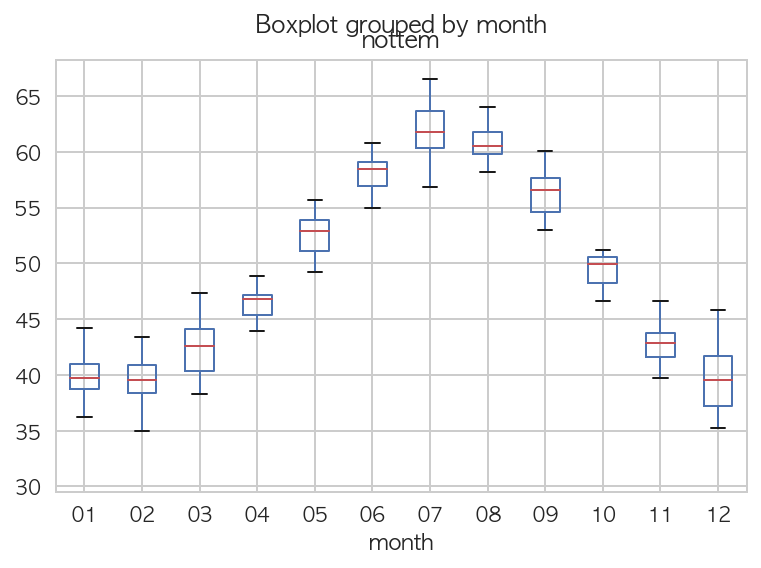

In [6]:
df.boxplot("nottem", "month")
plt.show()

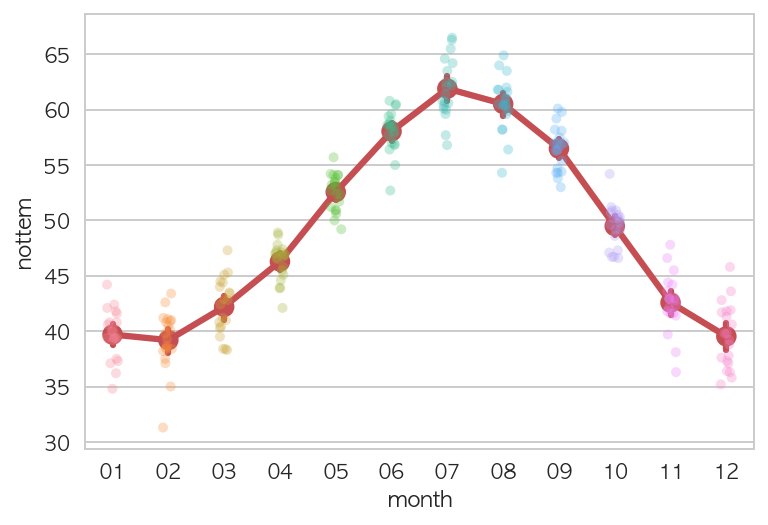

In [7]:
sns.stripplot(x="month", y="nottem", data=df, jitter=True, alpha=.3)
sns.pointplot(x="month", y="nottem", data=df, dodge=True, color='r')
plt.show()

In [8]:
model = sm.OLS.from_formula("nottem ~ C(month) + 0", df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 nottem   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     277.3
Date:                Sat, 10 Mar 2018   Prob (F-statistic):          2.96e-125
Time:                        06:04:37   Log-Likelihood:                -535.82
No. Observations:                 240   AIC:                             1096.
Df Residuals:                     228   BIC:                             1137.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(month)[01]    39.6950      0.518     76.691   

##### 보스턴 집값 데이터의 카테고리 변수
- 모델링을 할때 w0 를 사용
    - CHAS 강이 0일 경우, w0이 나옴 (찰스강 주변에 없을때의 가중치)
    - CHAS 강이 1일 경우, w0 + w1 이 나옴 
        (w0이 기준일때, w1만큼 차이 = 찰스강 프리미엄)

In [10]:
from sklearn.datasets import load_boston

boston = load_boston()
dfX0_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
dfX_boston = sm.add_constant(dfX0_boston)
dfy_boston = pd.DataFrame(boston.target, columns=["MEDV"])
df_boston = pd.concat([dfX_boston, dfy_boston], axis=1)

In [11]:
model = sm.OLS(dfy_boston, dfX_boston)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sat, 10 Mar 2018   Prob (F-statistic):          6.95e-135
Time:                        06:08:40   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4911      5.104      7.149      0.0

In [12]:
params1 = result.params.drop("CHAS")
params1

const      36.491103
CRIM       -0.107171
ZN          0.046395
INDUS       0.020860
NOX       -17.795759
RM          3.804752
AGE         0.000751
DIS        -1.475759
RAD         0.305655
TAX        -0.012329
PTRATIO    -0.953464
B           0.009393
LSTAT      -0.525467
dtype: float64

In [13]:
params2 = params1.copy()
params2["const"] += result.params["CHAS"]
params2

const      39.179665
CRIM       -0.107171
ZN          0.046395
INDUS       0.020860
NOX       -17.795759
RM          3.804752
AGE         0.000751
DIS        -1.475759
RAD         0.305655
TAX        -0.012329
PTRATIO    -0.953464
B           0.009393
LSTAT      -0.525467
dtype: float64

In [ ]:
### const의 차이 (39.179665 - 36.491103) : CHAS = 1일때의 레버리지 총합